In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision import transforms
import torch
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToPILImage
from models import *

In [2]:
class rellis_dataset(Dataset):
    """
    Using 6 classes
    """
    def __init__(self, data_root_dir, txt_file, transform=None, target_transform=None):
        """
        data_root_dit: root directory of the dataset, e.g. './data/rellis'
        txt_file: path to the train.txt listing image files
        
        """
        self.data_root_dir = data_root_dir
        self.transform = transform
        self.target_transform = target_transform
        with open(txt_file, 'r') as f:
            self.image_paths = [line.strip() for line in f.readlines()]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.data_root_dir, 'image', self.image_paths[index] + '.jpg')
        ann_path = os.path.join(self.data_root_dir, 'annotation', self.image_paths[index] + '_group6.png')
        image = Image.open(img_path).convert('RGB')
        annotation = Image.open(ann_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            annotation = self.target_transform(annotation)
        annotation = (annotation*256).long() # turn the label to the interger
        return image, annotation

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = make_SegFormerB0_with_boundary(6)  # Instantiate your model
model.load_state_dict(torch.load('model_b0_struct/best_segmentation_model_24.pth', map_location=device))
model.to('cuda')
model.eval()


Segformer_with_boundary(
  (mit): MiT(
    (stages): ModuleList(
      (0): ModuleList(
        (0): Unfold(kernel_size=7, dilation=1, padding=3, stride=4)
        (1): Conv2d(147, 32, kernel_size=(1, 1), stride=(1, 1))
        (2): ModuleList(
          (0-1): 2 x ModuleList(
            (0): PreNorm(
              (fn): EfficientSelfAttention(
                (to_q): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (to_kv): Conv2d(32, 64, kernel_size=(8, 8), stride=(8, 8), bias=False)
                (to_out): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              )
              (norm): LayerNorm()
            )
            (1): PreNorm(
              (fn): MixFeedForward(
                (net): Sequential(
                  (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1))
                  (1): DsConv2d(
                    (net): Sequential(
                      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [4]:

def calculate_iou(prediction, ground_truth, num_classes):
    ious = []
    for c in range(num_classes):
        # True Positive (Intersection)
        intersection = np.logical_and(prediction == c, ground_truth == c).sum()
        
        # Union
        union = np.logical_or(prediction == c, ground_truth == c).sum()
        
        if union == 0:
            ious.append(np.nan)  # If no pixels are present for this class
        else:
            ious.append(intersection / union)
    
    return np.array(ious)

In [5]:
def decode_boundary(boundary):
    # Move the boundary tensor to CPU and apply a threshold to create a binary mask
    threshold = 0.5  # Adjust threshold as needed
    binary_boundary = (boundary.squeeze(0).cpu().numpy() > threshold).astype(np.uint8)
    return binary_boundary

In [6]:


# Transform definitions
transform = transforms.Compose([
 transforms.Resize((256,256)), 
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
target_transform = transforms.Compose([
    transforms.Resize((256,256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
]) 


dataset = rellis_dataset(data_root_dir='./data/rellis', txt_file='./data/rellis/test.txt', transform=transform, target_transform=target_transform)

label_colors = {
    0: [0, 0, 0],         # Background: black
    1: [255, 223, 186],   # Level1 (smooth) - Navigable: light peach
    2: [173, 255, 47],    # Level2 (rough) - Navigable: light green
    3: [255, 215, 0],     # Level3 (bumpy) - Navigable: gold
    4: [70, 130, 180],     # Non-Navigable (forbidden): steel blue
    5: [255, 69, 0],      # Obstacle: crimson
}
label_names = {
    0: "Background",
    1: "Level1 (smooth)",
    2: "Level2 (rough)",
    3: "Level3 (bumpy)",
    4: "Non-Navigable",
    5: "Obstacle",
}

# Function to decode segmentation map to color
def decode_segmap(annotation):
    annotation_np = annotation.squeeze(0).numpy() 
    color_annotation = np.zeros((annotation_np.shape[0], annotation_np.shape[1], 3), dtype=np.uint8)

    for label, color in label_colors.items():
        color_annotation[annotation_np == label] = color

    return color_annotation

In [7]:


# # Select an image from the dataset 1100
# image, _ = dataset[100]  
# image_tensor = image.unsqueeze(0).to(device)

# # Get model predictions
# with torch.no_grad():
#     output, ax_info = model(image_tensor)
#     # Assuming output is of shape (batch_size, num_classes, height, width)
#     predicted_mask = torch.argmax(output, dim=1)  # Get the predicted class for each pixel

# # Decode predicted mask
# color_predicted_mask = decode_segmap(predicted_mask.cpu())
# # calcuate iou
# ious = calculate_iou(predicted_mask.cpu(), _, 6)
# miou = np.nanmean(ious)


# print(f"IoU per class: {ious}")
# print(f"Mean IoU: {miou}")
# # Plotting
# fig, ax = plt.subplots(1, 3, figsize=(18, 6))
# # Original Image
# ax[0].imshow(ToPILImage()(image))
# ax[0].set_title('Original Image')
# ax[0].axis('off')

# # Colored Annotation
# ax[1].imshow(decode_segmap(_))  # Using the original annotations
# ax[1].set_title('Original Annotation')
# ax[1].axis('off')

# # Predicted Segmentation
# ax[2].imshow(color_predicted_mask)
# ax[2].set_title('Predicted Segmentation')
# ax[2].axis('off')

# # Legend for colors
# handles = []
# for label, color in label_colors.items():
#     handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label_names[label],
#                                 markerfacecolor=np.array(color) / 255, markersize=10))

# ax[1].legend(handles=handles, title="Labels", loc='upper right', bbox_to_anchor=(1.1, 1.0))

# plt.show()


IoU per class: [0.81541854 0.73007905 0.23593979        nan 0.49977347 0.24088478]
Mean IoU: 0.5044191271066666


/tmp/ipykernel_475854/4273542134.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  intersection = np.logical_and(prediction == c, ground_truth == c).sum()
/tmp/ipykernel_475854/4273542134.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  union = np.logical_or(prediction == c, ground_truth == c).sum()


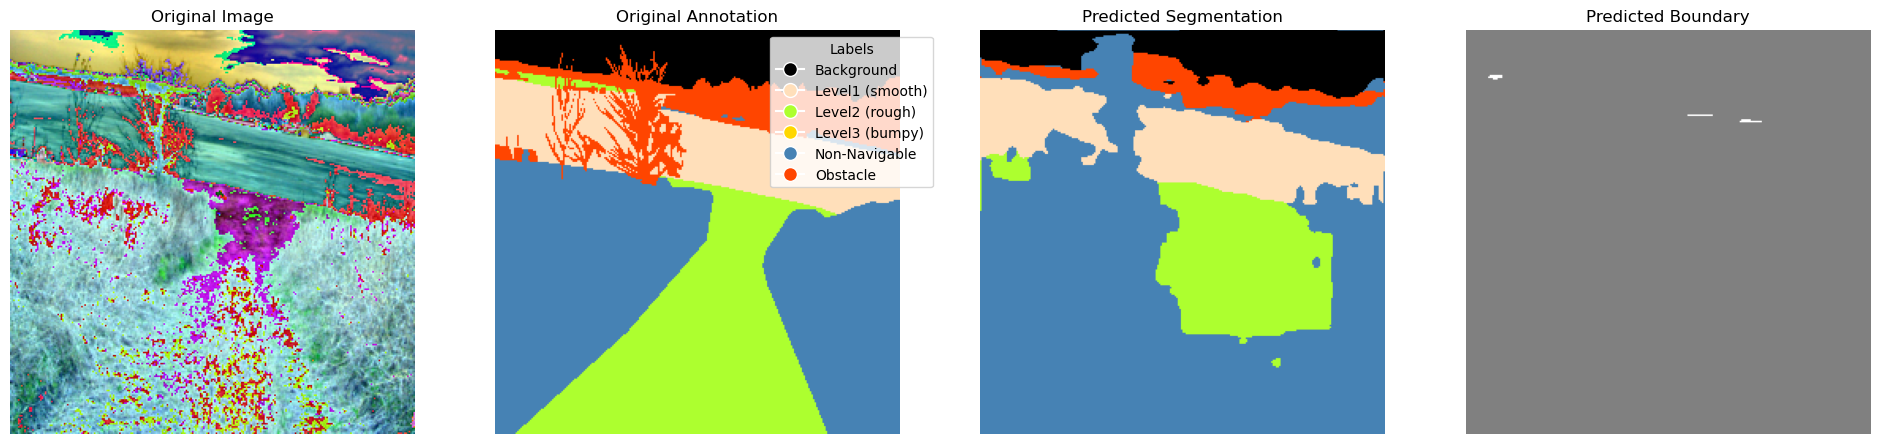

In [8]:
# Select an image from the dataset (index 1001)
image, boundary = dataset[1001]  
image_tensor = image.unsqueeze(0).to(device)

# Get model predictions
with torch.no_grad():
    output, boundary_out = model(image_tensor)  # Get segmentation and boundary predictions
    predicted_mask = torch.argmax(output, dim=1)  # Get the predicted class for each pixel
    binary_boundary = decode_boundary(boundary_out)  # Decode the boundary predictions

# Decode predicted mask
color_predicted_mask = decode_segmap(predicted_mask.cpu())

# Calculate IoU
ious = calculate_iou(predicted_mask.cpu(), boundary, 6)  # Assuming boundary is the true annotation
miou = np.nanmean(ious)

print(f"IoU per class: {ious}")
print(f"Mean IoU: {miou}")

# Plotting
fig, ax = plt.subplots(1, 4, figsize=(24, 6))  # Adjusted for 4 subplots
# Original Image
ax[0].imshow(ToPILImage()(image))
ax[0].set_title('Original Image')
ax[0].axis('off')

# Colored Annotation
ax[1].imshow(decode_segmap(boundary))  # Using the original annotations
ax[1].set_title('Original Annotation')
ax[1].axis('off')

# Predicted Segmentation
ax[2].imshow(color_predicted_mask)
ax[2].set_title('Predicted Segmentation')
ax[2].axis('off')

# Predicted Boundary
ax[3].imshow(binary_boundary.squeeze(0), cmap='gray', alpha=0.5)  # Display the binary boundary mask
ax[3].set_title('Predicted Boundary')
ax[3].axis('off')

# Legend for colors
handles = []
for label, color in label_colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label_names[label],
                                markerfacecolor=np.array(color) / 255, markersize=10))

ax[1].legend(handles=handles, title="Labels", loc='upper right', bbox_to_anchor=(1.1, 1.0))

plt.show()
